# Step 1: Importing Libraries and Preparation


In [ ]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version', tf.__version__)

Tensorflow version 2.2.0


## Important Function to show the images

In [ ]:
def show(images, n_cols = None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1 
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis = -1)
    plt.figure(figsize = (n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap = 'binary')
        plt.axis("off")

# Step 2: Loading and Preprocessing the Data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0 

4423680/4422102 [==============================] - 0s 0us/step


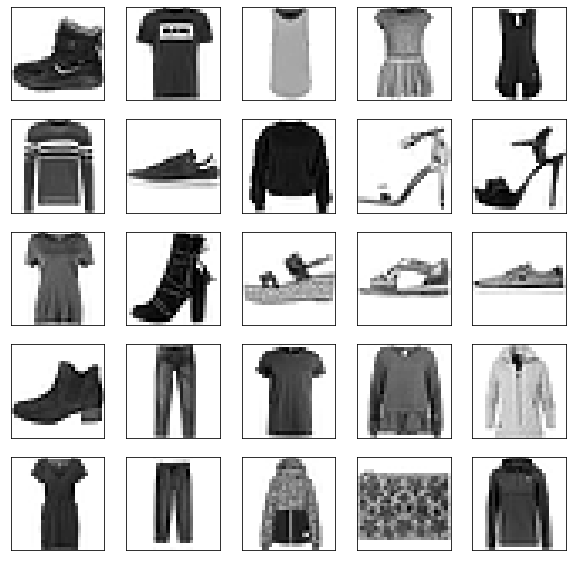

In [ ]:
plt.figure(figsize = (10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap = plt.cm.binary)

# Step 3: Creating Batches of Training Data

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

# Step 4: Building the Generator Network for DCGAN
![alt text](https://image.slidesharecdn.com/20170327discogans-170330041734/95/discogan-16-638.jpg?cb=1490847550)

In [ ]:
num_features = 100

generator = keras.models.Sequential([
  keras.layers.Dense(7 * 7 * 256, input_shape = [num_features]),
  keras.layers.Reshape([7, 7, 256]),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(256, (5, 5), (2, 2), padding = 'same', activation = 'selu'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(128, (5, 5), (1, 1), padding = 'same', activation = 'selu'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(64, (5, 5), (1, 1), padding = 'same', activation = 'selu'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(32, (5, 5), (2, 2), padding = 'same', activation = 'selu'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(1, (5, 5), (1, 1), padding = 'same', activation = 'tanh')
])
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 256)         1024      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 256)       1638656   
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       819328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       5

TensorShape([1, 28, 28, 1])

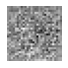

In [ ]:
noise = tf.random.normal(shape = [1, num_features])
generated_image = generator(noise, training = False)
show(generated_image, 1)
generated_image.shape

# Step 5: Building the Discriminator Network for DCGAN
![alt text](https://image.slidesharecdn.com/20170327discogans-170330041734/95/discogan-17-638.jpg?cb=1490847550)

In [ ]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), (2, 2), padding = 'same', input_shape = [28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64, (5, 5), (2, 2), padding = 'same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5, 5), (2, 2), padding = 'same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(256, (5, 5), (2, 2), padding = 'same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation = 'sigmoid')
])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)        

In [ ]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.50124586]], shape=(1, 1), dtype=float32)


# Step 6: Compile the DCGAN

In [ ]:
optim = tf.keras.optimizers.Adam(lr = 2e-4, beta_1 = 0.5)
discriminator.compile(loss = 'binary_crossentropy', optimizer = optim)
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss = 'binary_crossentropy', optimizer = optim)

# Step 7: Defining Training Procedure

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training = False)
    fig = plt.figure(figsize = (28, 28))

    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap = 'binary')
        plt.axis('off')
    plt.savefig('image_at_epoch{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
seed = tf.random.normal(shape = [batch_size, num_features])

In [ ]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs = 5):
  generator, discriminator = gan.layers
  for epoch in tqdm(range(epochs)):
      print("Epoch {}/{}".format(epoch + 1, epochs))
      for X_batch in dataset:
          noise = tf.random.normal(shape = [batch_size, num_features])
          generated_images = generator(noise)
          X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
          y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
          discriminator.trainable = True
          discriminator.train_on_batch(X_fake_and_real, y1)
          y2 = tf.constant([[1.]] * batch_size)
          discriminator.trainable = False
          gan.train_on_batch(noise, y2)
      display.clear_output(wait = True)
      generate_and_save_images(generator, epoch + 1, seed)
  display.clear_output(wait = True)
  generate_and_save_images(generator, epochs, seed)


# Step 8: Training DCGAN

In [ ]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

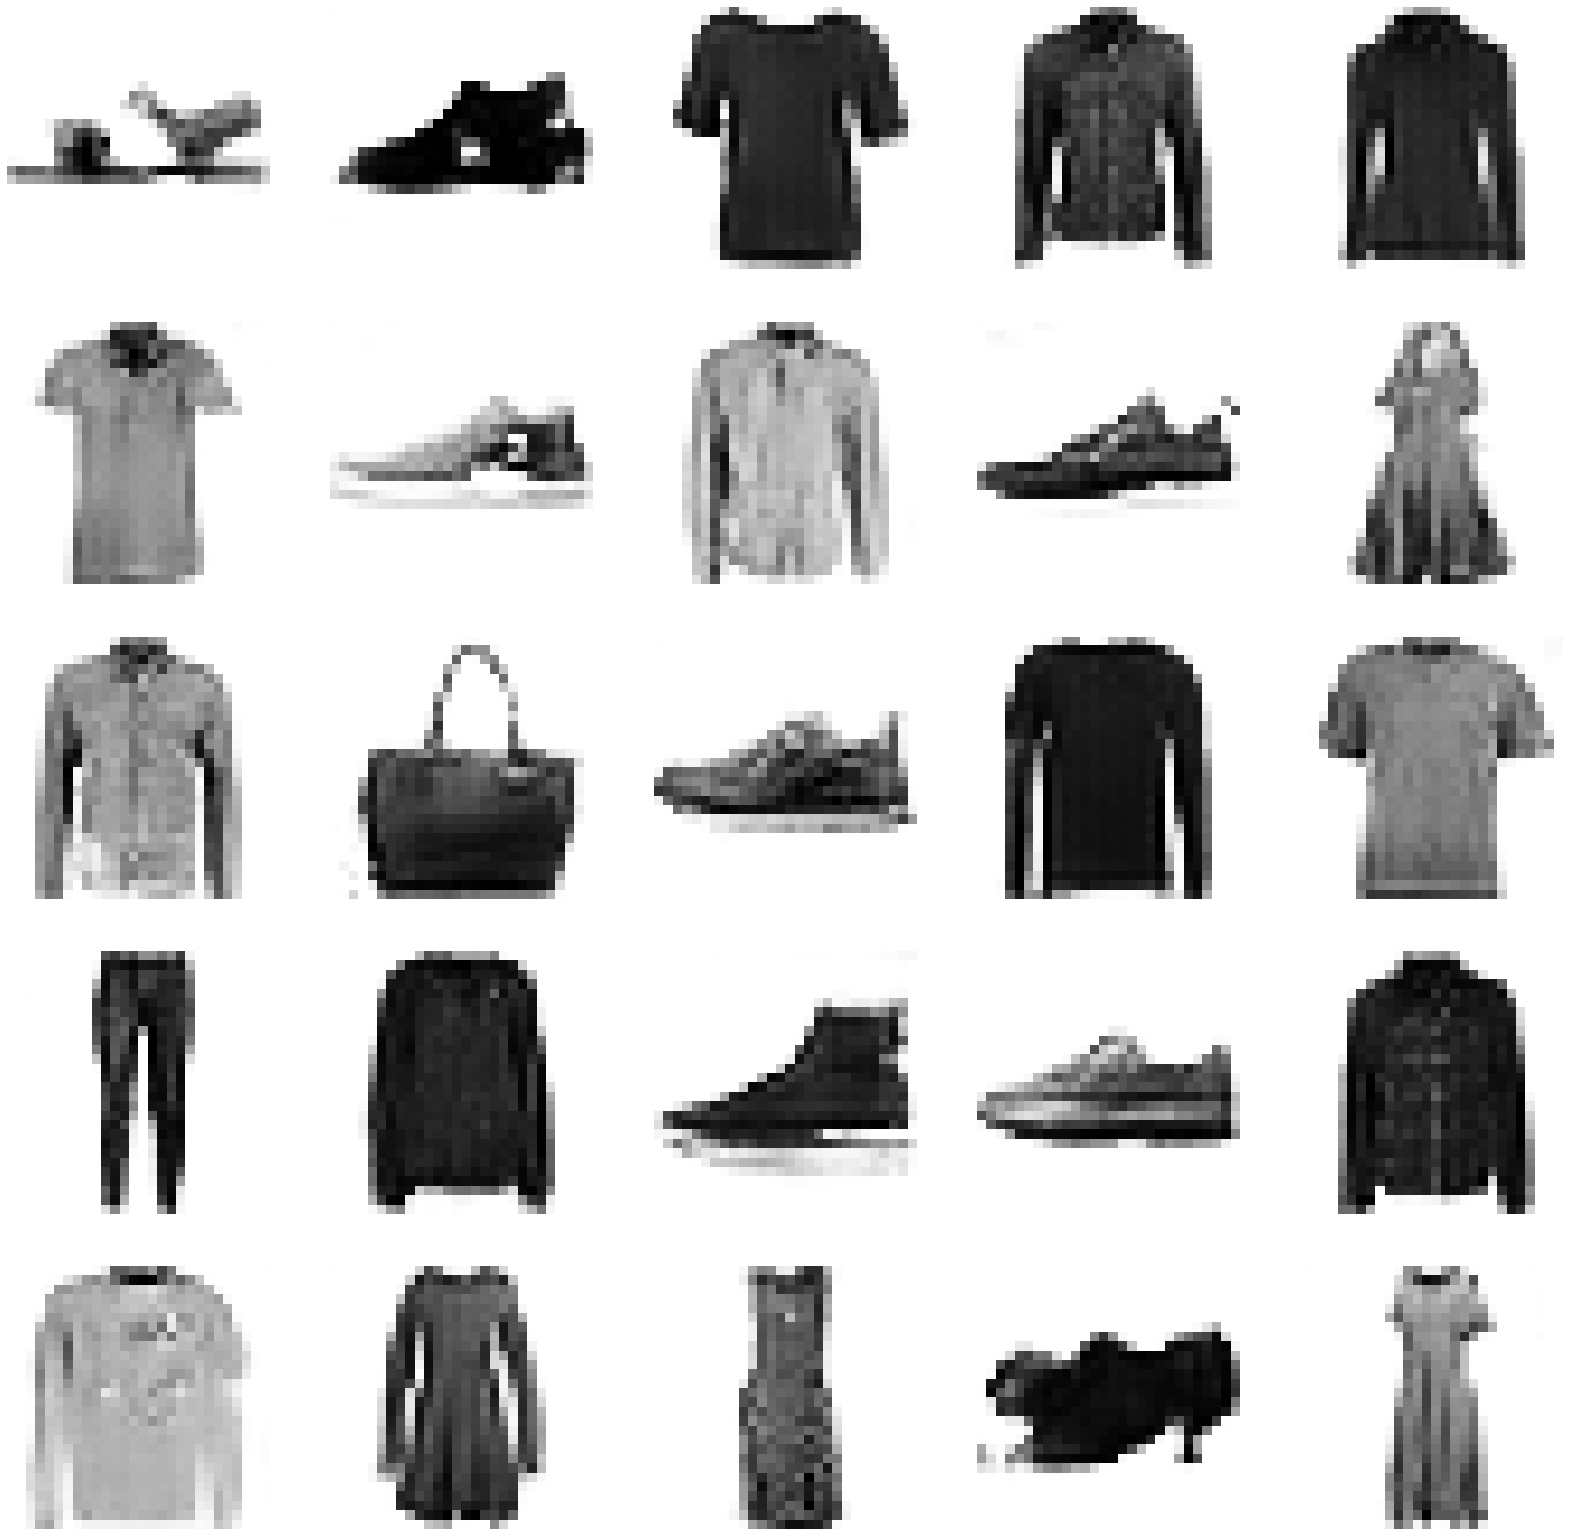

CPU times: user 58min 25s, sys: 4min 38s, total: 1h 3min 4s
Wall time: 2h 10min 43s


In [18]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs = 50)

# Step 9: Generating Synthetic Images with DCGAN

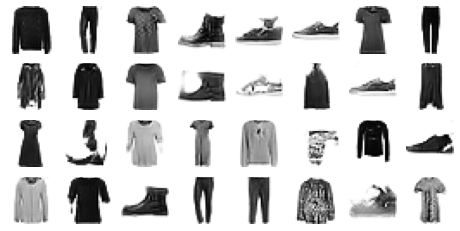

In [22]:
noise = tf.random.normal(shape = [batch_size, num_features])
generated_images = generator(noise)
show(generated_images, 8)

In [20]:
'''import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode = 'I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename = anim_file)'''

"import imageio\nimport glob\n\nanim_file = 'dcgan.gif'\n\nwith imageio.get_writer(anim_file, mode = 'I') as writer:\n    filenames = glob.glob('image*.png')\n    filenames = sorted(filenames)\n    last = -1\n    for i, filename in enumerate(filenames):\n        frame = 2 * (i ** 0.5)\n        if round(frame) > round(last):\n            last = frame\n        else:\n            continue\n        image = imageio.imread(filename)\n        writer.append_data(image)\n    image = imageio.imread(filename)\n    writer.append_data(image)\n\nimport IPython\ndisplay.Image(filename = anim_file)"